In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset

/home/shwu/prayog/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from pathlib import Path

MODEL = "sarvamai/OpenHathi-7B-Hi-v0.1-Base"
DATASET = "sarvamai/samvaad-hi-v1"

# paths
CUSTOM_DATA = Path("custom_data")

MODELS = CUSTOM_DATA / "models"
DATA = CUSTOM_DATA / "datasets"

MODEL_PATH = MODELS / "openhathi"
DATA_PATH = DATA / "samvaad"

In [3]:
print(f"MODEL: {MODEL}")
print(f"DATASET: {DATASET}")
print(f"CUSTOM_DATA: {CUSTOM_DATA.absolute()}")
print(f"MODELS: {MODELS.absolute()}")
print(f"DATA: {DATA.absolute()}")
print(f"MODEL_PATH: {MODEL_PATH.absolute()}")
print(f"DATA_PATH: {DATA_PATH.absolute()}")

MODEL: sarvamai/OpenHathi-7B-Hi-v0.1-Base
DATASET: sarvamai/samvaad-hi-v1
CUSTOM_DATA: /home/shwu/prayog/custom_data
MODELS: /home/shwu/prayog/custom_data/models
DATA: /home/shwu/prayog/custom_data/datasets
MODEL_PATH: /home/shwu/prayog/custom_data/models/openhathi
DATA_PATH: /home/shwu/prayog/custom_data/datasets/samvaad


### Dataset

Explore and format dataset for usage

In [4]:
ds = load_dataset(DATASET); ds

DatasetDict({
    train: Dataset({
        features: ['messages'],
        num_rows: 101476
    })
})

In [5]:
role_dict = []

for messages in ds["train"]["messages"]:
    convo_stats = {}
    for message in messages:
        convo_stats[message["role"]] = convo_stats.get(message["role"], 0) + 1
    role_dict.append(convo_stats)


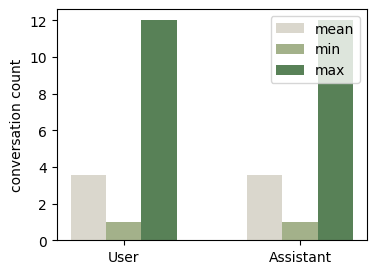

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.DataFrame(role_dict)

# Calculating mean, min, and max conversation exchanges between user and assistant
user_mean = df['user'].mean()
user_min = df['user'].min()
user_max = df['user'].max()

assistant_mean = df['assistant'].mean()
assistant_min = df['assistant'].min()
assistant_max = df['assistant'].max()

# Plotting
labels = ['User', 'Assistant']
x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(4,3))

# colors - https://coolors.co/palette/dad7cd-a3b18a-588157-3a5a40-344e41
bars_mean = ax.bar(x - width, [user_mean, assistant_mean], width, label='mean', color='#DAD7CD')
bars_min = ax.bar(x, [user_min, assistant_min], width, label='min', color='#A3B18A')
bars_max = ax.bar(x + width, [user_max, assistant_max], width, label='max', color='#588157')

ax.set_ylabel('conversation count')
# ax.set_title('mean, min, and max conversation counts between User and Assistant')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

#### Prepare DataSets

We prepare two datasets for testing purposes; One following the tulu format and the other follows alpaca format (both are chat/instruction formats)

In [7]:
CHAT = "chat"
TULU = "tulu"
EOL = "\n"
SPACE = " "

ROLE_TOS = {
    CHAT: {
        "user": f"user:{SPACE}",
        "system": f"system:{SPACE}",
        "assistant": f"assistant:{SPACE}",
    },
    TULU: {
        "user": f"<|user|>{EOL}",
        "system": f"<|system|>{EOL}",
        "assistant": f"<|assistant|>{EOL}",
    }
}

# 1. Tulu format
# Adapted from AI4Bharat/IndicInstruct - https://github.com/AI4Bharat/IndicInstruct/blob/0d22aa33f6322d917bb83876e5fa877fb9edb2f2/eval/templates.py#L1

def create_prompt_with_tulu_chat_format(messages, bos="<s>", eos="</s>", add_bos=True):
    formatted_text = ""
    for message in messages:
        if message["role"] == "system":
            formatted_text += ROLE_TOS[TULU][message["role"]] + message["content"] + EOL
        elif message["role"] == "user":
            formatted_text += ROLE_TOS[TULU][message["role"]] + message["content"] + EOL
        elif message["role"] == "assistant":
            formatted_text += ROLE_TOS[TULU][message["role"]] + \
                message["content"].strip() + eos + EOL
        else:
            raise ValueError(
                "Tulu chat template only supports 'system', 'user' and 'assistant' roles. Invalid role: {}.".format(
                    message["role"]
                )
            )

    formatted_text = bos + formatted_text if add_bos else formatted_text
    return formatted_text

# 2. Chat format

def create_prompt_with_chat_format(messages):
    formatted_text = ""
    for message in messages:
        if message["role"] in { "system", "user", "assistant"}:
            formatted_text += ROLE_TOS[CHAT][message["role"]] + message["content"] + EOL
        else:
            raise ValueError(
                "Alpaca template only supports 'system', 'user' and 'assistant' roles. Invalid role: {}.".format(
                    message["role"]
                )
            )
    return formatted_text

In [8]:
map_funcs = [
    (CHAT, lambda ds_row: {
        "text": create_prompt_with_chat_format(messages=ds_row["messages"])
    }), 
    (TULU, lambda ds_row: {
        "text": create_prompt_with_tulu_chat_format(messages=ds_row["messages"])
    })
]

In [ ]:
# push to hub
    
for (f_name, func) in map_funcs:
    ds = ds = load_dataset(DATASET)
    ds["train"] = ds["train"].map(func)
    ds.push_to_hub(f"shwubham/samvaad-hi-v1-{f_name}-format")

    for sample in ds["train"]["text"][-2:]:
        print(sample)
        print("=" * 100, "\n")
    
    # save dataset
    ds.save_to_disk(DATA_PATH / f_name)

    del ds

### Results

In [2]:
from pathlib import Path

# RESULTS = Path("results")

from pathlib import Path
import json
import pandas as pd

class Metrics:
    def __init__(self, accuracy, precision, recall, f1):
        self.accuracy = accuracy
        self.precision = precision
        self.recall = recall
        self.f1 = f1
    
    @classmethod
    def from_json(cls, json_file):
        with open(json_file, "r") as f:
            data = json.load(f)
            return cls(
                accuracy=data["accuracy"],
                precision=data["precision"],
                recall=data["recall"],
                f1=data["f1"]
            )

# Define the results directory
results_dir = Path("results")

# Create a dictionary to store the results
results_data = {
    "challenge": [],
    "model": [],
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1": []
}

# Loop through each challenge directory
for challenge_dir in results_dir.iterdir():
    if challenge_dir.is_dir():
        challenge_name = challenge_dir.name
        # Loop through each model directory within the challenge directory
        for model_dir in challenge_dir.iterdir():
            if model_dir.is_dir():
                model_name = model_dir.name
                # Read metrics.json file
                metrics_file = model_dir / "metrics.json"
                if metrics_file.exists():
                    metrics = Metrics.from_json(metrics_file)
                    # Append data to results dictionary
                    results_data["challenge"].append(challenge_name)
                    results_data["model"].append(model_name.replace("-awq-4-samvaad-hi-v1", "-4bit-quantized"))
                    results_data["accuracy"].append(metrics.accuracy)
                    results_data["precision"].append(metrics.precision)
                    results_data["recall"].append(metrics.recall)
                    results_data["f1"].append(metrics.f1)

# Create DataFrame from results dictionary
results_df = pd.DataFrame(results_data)

# Print the DataFrame
# print(results_df)
results_df

,challenge,model,accuracy,precision,recall,f1
0,arc-easy-hi,openhathi-4bit-quantized-chat-format-5shot,0.354798,0.351789,0.281421,0.248957
1,arc-easy-hi,openhathi-4bit-quantized-chat-format-0shot,0.297138,0.355233,0.235650,0.161711
2,arc-easy-hi,openhathi-4bit-quantized-tulu-format-5shot,0.371633,0.334755,0.294419,0.274674
3,arc-easy-hi,openhathi-4bit-quantized-tulu-format-0shot,0.314394,0.352865,0.248770,0.187303
4,arc-easy-hi,openhathi-awq-4-wikitext-0shot,0.329966,0.307654,0.257177,0.214812
5,arc-easy-hi,openhathi-awq-4-wikitext-5shot,0.389310,0.324202,0.306374,0.296121
6,arc-easy-hi,OpenHathi-7B-Hi-v0.1-Base-0shot,0.354377,0.349071,0.279607,0.240419
7,arc-easy-hi,OpenHathi-7B-Hi-v0.1-Base-5shot,0.401515,0.347235,0.317889,0.302610
8,hellaswag,OpenHathi-7B-Hi-v0.1-Base-0shot,0.315077,0.338783,0.310890,0.276280
9,arc-easy,openhathi-4bit-quantized-chat-format-5shot,0.571970,0.516349,0.453559,0.441252


In [3]:
# Grouping the DataFrame by challenge
grouped_df = results_df.groupby("challenge")

# Printing a nice representation of the grouped DataFrame
for challenge, group in grouped_df:
    print(f"Challenge: {challenge}\n")
    print(group.to_string(index=False))
    print("\n")


Challenge: arc-challenge

    challenge                                      model  accuracy  precision   recall       f1
arc-challenge openhathi-4bit-quantized-chat-format-5shot  0.408703   0.502110 0.416118 0.378141
arc-challenge openhathi-4bit-quantized-chat-format-0shot  0.371160   0.472790 0.375792 0.326097
arc-challenge openhathi-4bit-quantized-tulu-format-5shot  0.433447   0.507943 0.438160 0.411062
arc-challenge openhathi-4bit-quantized-tulu-format-0shot  0.374573   0.487077 0.378759 0.333371
arc-challenge             openhathi-awq-4-wikitext-0shot  0.369454   0.481443 0.361930 0.317903
arc-challenge             openhathi-awq-4-wikitext-5shot  0.448805   0.503799 0.447331 0.429478
arc-challenge            OpenHathi-7B-Hi-v0.1-Base-0shot  0.402730   0.497768 0.400616 0.361227
arc-challenge            OpenHathi-7B-Hi-v0.1-Base-5shot  0.459044   0.527952 0.463042 0.439510


Challenge: arc-challenge-hi

       challenge                                      model  accuracy  precisio